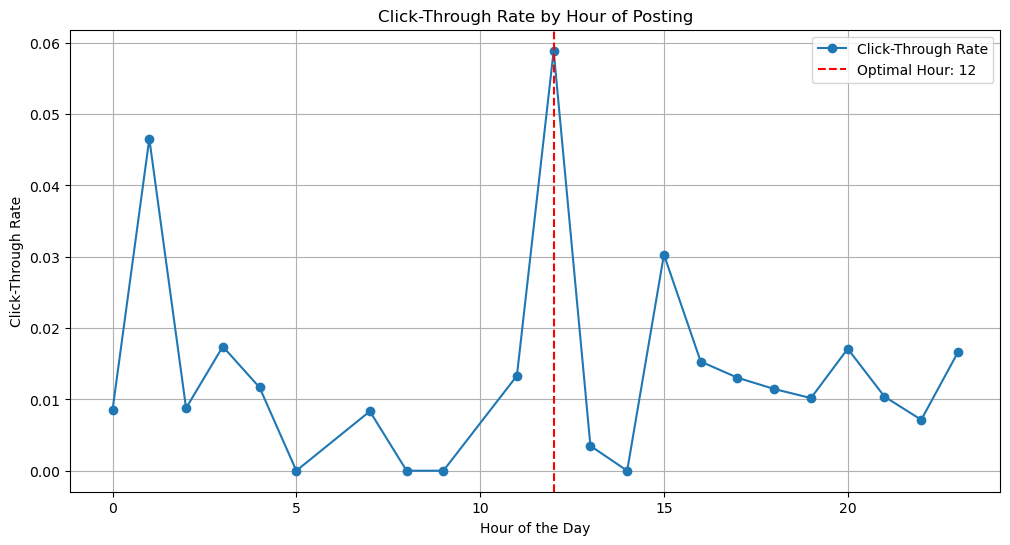

<Figure size 1000x500 with 0 Axes>

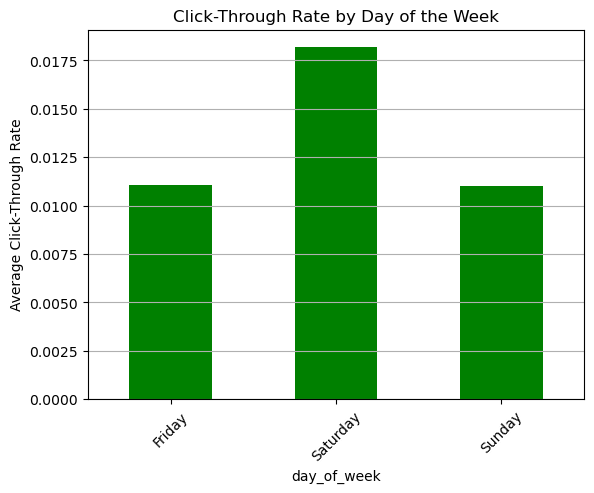

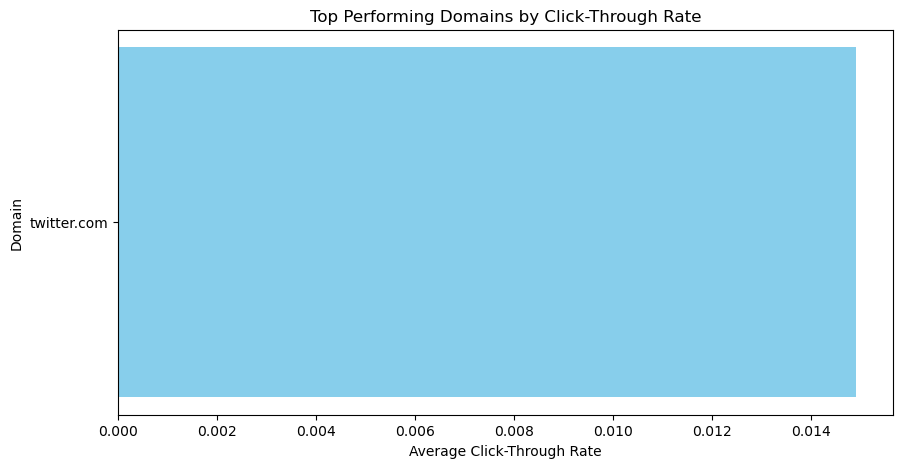

Top Performing Domains:
             total_views  total_likes  avg_click_rate
domain                                               
twitter.com        69121          908         0.01492

Optimal Posting Hour: 12

Click-Through Rate by Day of the Week:
             avg_click_rate
day_of_week                
Friday             0.011065
Saturday           0.018180
Sunday             0.011009


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = r"C:\Users\New\Desktop\Semester\Projects\A_rta_Project\cleaned_data_twitter.csv"
data = pd.read_csv(file_path)

# ✅ Handle missing values
data = data.dropna(subset=['likes', 'views', 'date_posted'])  # Remove rows with missing engagement or dates

# ✅ Function to convert likes/views to numbers (handles "10K", "5M", etc.)
def convert_numeric(value):
    if isinstance(value, str):
        value = value.lower().replace(',', '')  # Remove commas
        if 'k' in value:
            return float(re.findall(r'\d+', value)[0]) * 1_000
        elif 'm' in value:
            return float(re.findall(r'\d+', value)[0]) * 1_000_000
    return pd.to_numeric(value, errors='coerce')

# Convert likes and views properly
data['likes'] = data['likes'].astype(str).apply(convert_numeric).fillna(0)
data['views'] = data['views'].astype(str).apply(convert_numeric).fillna(0)

# ✅ Remove rows where views are zero (since CTR will be 0)
data = data[data['views'] > 0]

# ✅ Step 1: Click-Through Rate Calculation (Avoid division by zero)
data['click_through_rate'] = data['likes'] / data['views']

# ✅ Step 2: Extract domain only if URL exists
data['domain'] = data['url'].dropna().astype(str).str.extract(r'https?://([^/]+)/')[0]
data['domain'] = data['domain'].fillna("Unknown")  # Fill missing domains

# ✅ Show Top 10 domains
domain_performance = data.groupby('domain').agg(
    total_views=('views', 'sum'),
    total_likes=('likes', 'sum'),
    avg_click_rate=('click_through_rate', 'mean')
).sort_values(by='avg_click_rate', ascending=False)

# ✅ Step 3: Fix Date Parsing & Time Analysis
data['date_posted'] = pd.to_datetime(data['date_posted'], errors='coerce', utc=True)
data = data.dropna(subset=['date_posted'])  # Drop invalid dates
data['hour_posted'] = data['date_posted'].dt.hour
data['day_of_week'] = data['date_posted'].dt.day_name()

# ✅ Step 4: Temporal Analysis - Best Time to Post
hourly_performance = data.groupby('hour_posted').agg(
    avg_click_rate=('click_through_rate', 'mean'),
    total_views=('views', 'sum')
)

# ✅ Fix: Remove empty hours
hourly_performance = hourly_performance[hourly_performance['total_views'] > 0]

# ✅ Fix: Check for empty data before finding `idxmax()`
if not hourly_performance.empty and not hourly_performance['avg_click_rate'].isna().all():
    optimal_hour = hourly_performance['avg_click_rate'].idxmax()
else:
    optimal_hour = "No Data"

# ✅ Step 5: Best Day to Post Analysis
daily_performance = data.groupby('day_of_week').agg(avg_click_rate=('click_through_rate', 'mean'))
sorted_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_performance = daily_performance.reindex(sorted_days)  # Sort days properly

# ✅ Remove NaN days
daily_performance = daily_performance.dropna()

# ✅ Fix: Avoid Empty Chart
if not hourly_performance.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(hourly_performance.index, hourly_performance['avg_click_rate'], marker='o', label='Click-Through Rate')
    plt.title('Click-Through Rate by Hour of Posting')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Click-Through Rate')
    if optimal_hour != "No Data":
        plt.axvline(optimal_hour, color='red', linestyle='--', label=f'Optimal Hour: {optimal_hour}')
    plt.legend()
    plt.grid()
    plt.show()

if not daily_performance.empty:
    plt.figure(figsize=(10, 5))
    daily_performance.plot(kind='bar', legend=False, color='green')
    plt.ylabel("Average Click-Through Rate")
    plt.title("Click-Through Rate by Day of the Week")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# ✅ Show Top 10 Domains
top_domains = domain_performance.head(10).sort_values(by='avg_click_rate', ascending=True)
if not top_domains.empty:
    plt.figure(figsize=(10, 5))
    plt.barh(top_domains.index, top_domains['avg_click_rate'], color='skyblue')
    plt.xlabel("Average Click-Through Rate")
    plt.ylabel("Domain")
    plt.title("Top Performing Domains by Click-Through Rate")
    plt.show()

# Print domain performance and suggestions
print("Top Performing Domains:")
print(domain_performance.head(10))

print(f"\nOptimal Posting Hour: {optimal_hour}")
print("\nClick-Through Rate by Day of the Week:")
print(daily_performance)
